# Advanced Lane Finding Project Pipeline 
**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# import libraries necessary
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib inline

## 1. Read undistortion parameter
* By using the unsitortion matrix which was from camera calibration. With 'pickle.load' function, I readed calibration matrix 'mtx' and distortion matrix 'dist' from camera calibaration.

In [2]:
#load distortion matrix from camera_cal
with open('./camera_cal/wide_dist_pickle.p',mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle['mtx']
    dist = dist_pickle["dist"]
print('mtx matrix and distortion matrix loaded')

mtx matrix and distortion matrix loaded


## 2. The single image-processing functions
### 2.1 Image read and undistorted

Original image


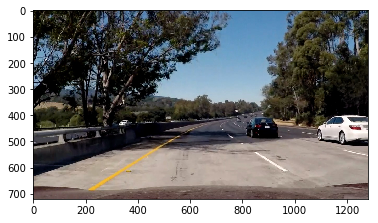

In [3]:
#read BGR&RGB image 
img = cv2.imread('test_images/test5.jpg')
image = mpimg.imread('test_images/test5.jpg')
print('Original image')
plt.imshow(image)

In [4]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

Undistorted image


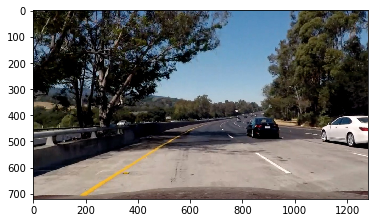

In [5]:
print('Undistorted image')
plt.imshow(undistort(image))

### 2.2 Image binarization and channels display
* In order to extract useful features from image, I have to do some preprocessing. In this project, since the line in left side is always yellow, so the color space transform was used. HLS color space method was used in this pipeline. After that, I need edges of the image, so I used sobel operation in x direction and y direction.I also used lightness 'L' in HLS color space.  By tuning the threshold in s channel, sx channel and l channel,the final combined binary image output was returned by the function binarize(). 
* The pixels accorded to the thresholds are considered as 'hot pixel'. 'hot pixel' formed a new binary image. This new image contains HLS information and edges information. Next , I tried to give it a ROI to filtering the useless pixels.

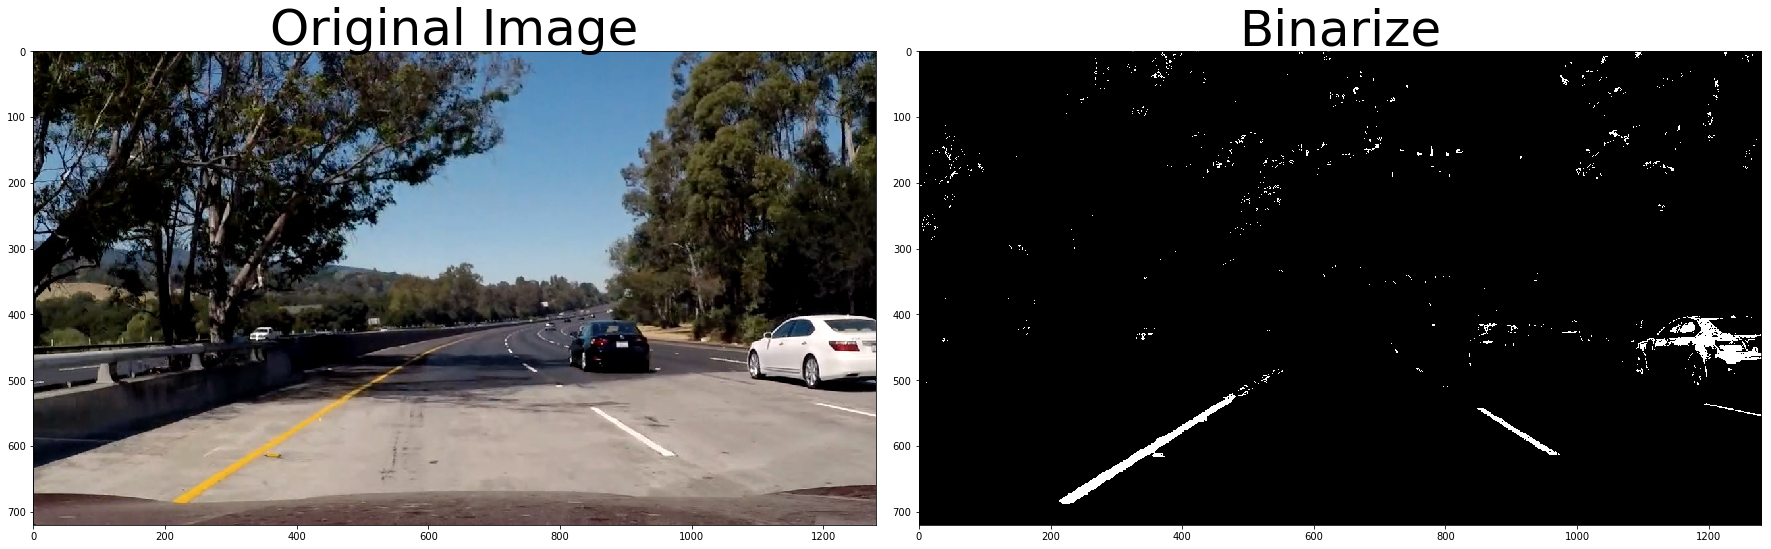

In [6]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)    
    # Convert to HLS color space and get the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    #red:binary l channel;green: binary s channel;blue:binary x gradient of s channel  
    channels = 255*np.dstack(( l_binary, s_binary, sxbinary)).astype('uint8')        
    
    # 'hot pixels' extract
    R = img[:,:,0]    
    thresh = (200, 255)
    R_binary = np.zeros_like(R)
    R_binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    #Combine the four binary thresholds    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (s_binary == 1) | (R_binary == 1)&(sxbinary==1))] = 1
    combined_binary = 255*np.dstack((combined_binary,combined_binary,combined_binary)).astype('uint8')            
    return  combined_binary,channels
    
binarize_image,channels = binarize(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binarize_image, cmap='gray')
ax2.set_title('Binarize', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

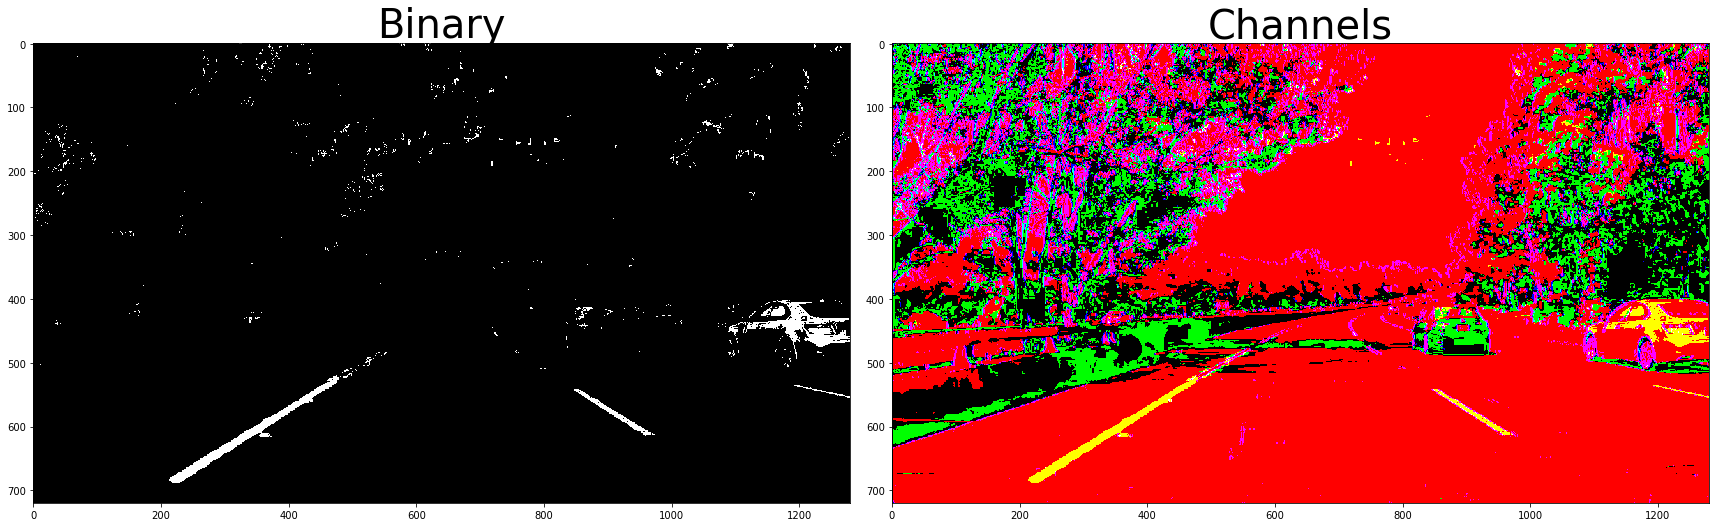

In [7]:
img = cv2.imread('test_images/test5.jpg')

shape = img.shape
binary,channels = binarize(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(channels)
ax2.set_title('Channels', fontsize=40)

### 2.3 Perspective Transform
* The code for my perspective transform includes a function called `warp()`. This function receives a image and based on the predefined source points ('scr') and destination points ('dst'). Then output is warped image based on 'src','dst'perspective relationship.

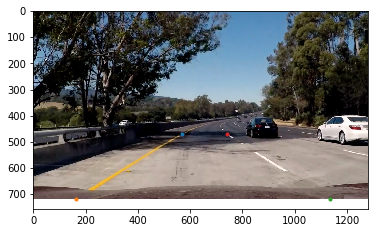

In [8]:
# the choosen source point was selected as below

plt.imshow(image)
plt.plot(570,470,'.')
plt.plot(165,720,'.')
plt.plot(1135,720,'.')
plt.plot(740,470,'.')


* The corner in warp() function set as below.

corners = np.float32([[570,470],[165,720], [1135,720],[740,470]])

* The offset defined as below

offset = 150

* The destination function was setted as below. With this destination function , I can extract the line's function more easily in x-y coordinate.

dst = np.float32([[150, 0], [150, 1280],[570, 1280],[570,0]])   

* By using the 'cv2.getPerspectiveTransfrom(src,dst)'function and 'cv2.warpPersperctive) function , finally generats warped image.
* Warped image size is (720, 1280, 3)
        

In [9]:
corners = np.float32([[570,470],[165,720], [1135,720],[740,470]])
def warp(img,tobird=True):
    offset = 150    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [corners[0],
         corners[1],
         corners[2],
         corners[3]])    
    dst = np.float32([
        [offset, 0], 
        [offset, img_size[1]],                         
        [img_size[0] - offset, img_size[1]],            
        [img_size[0] - offset,0]])  

    if tobird:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

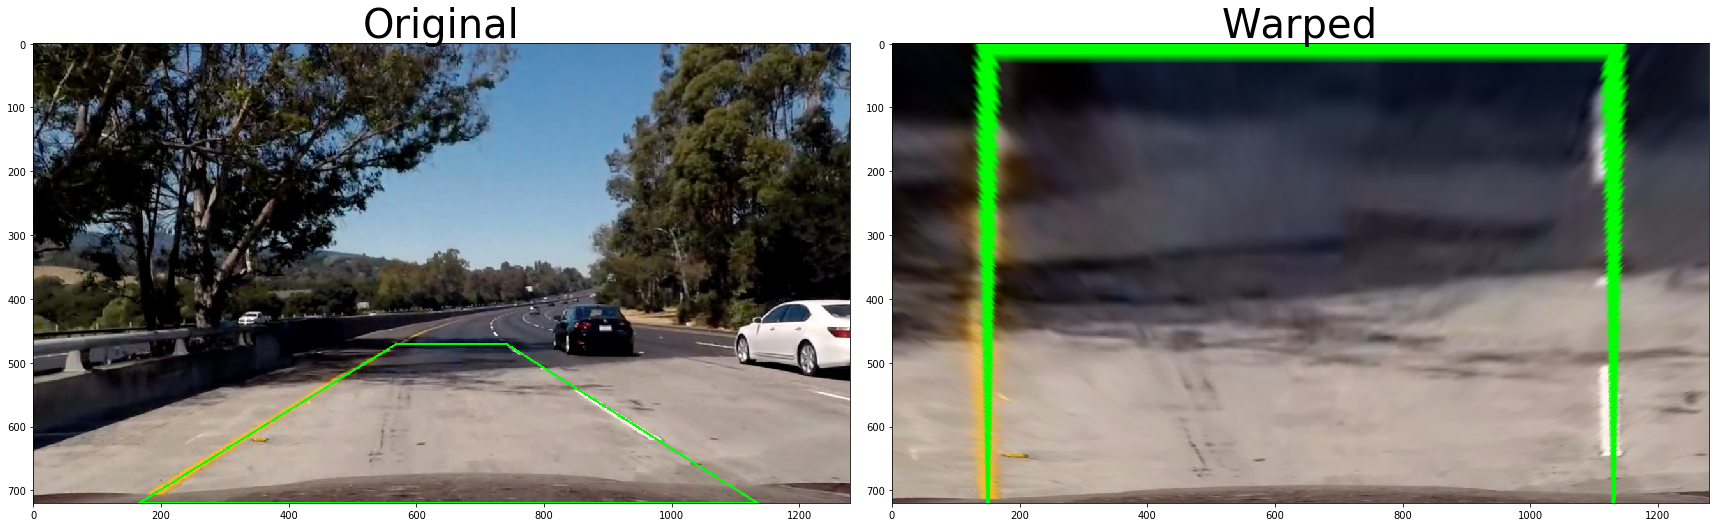

In [10]:
img=plt.imread('test_images/test5.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[0,255,0], thickness=2)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[0,255,0], thickness=2)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[0,255,0], thickness=2)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[0,255,0], thickness=2)

warped_img= warp(img) 

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original', fontsize=40)

ax2.imshow(warped_img)
ax2.set_title('Warped', fontsize=40)

### 2.4 Get the the region of interest in image 

In [11]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(shape[1],shape[0]),
                      (shape[1]/13,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### 2.5 Some combined functions

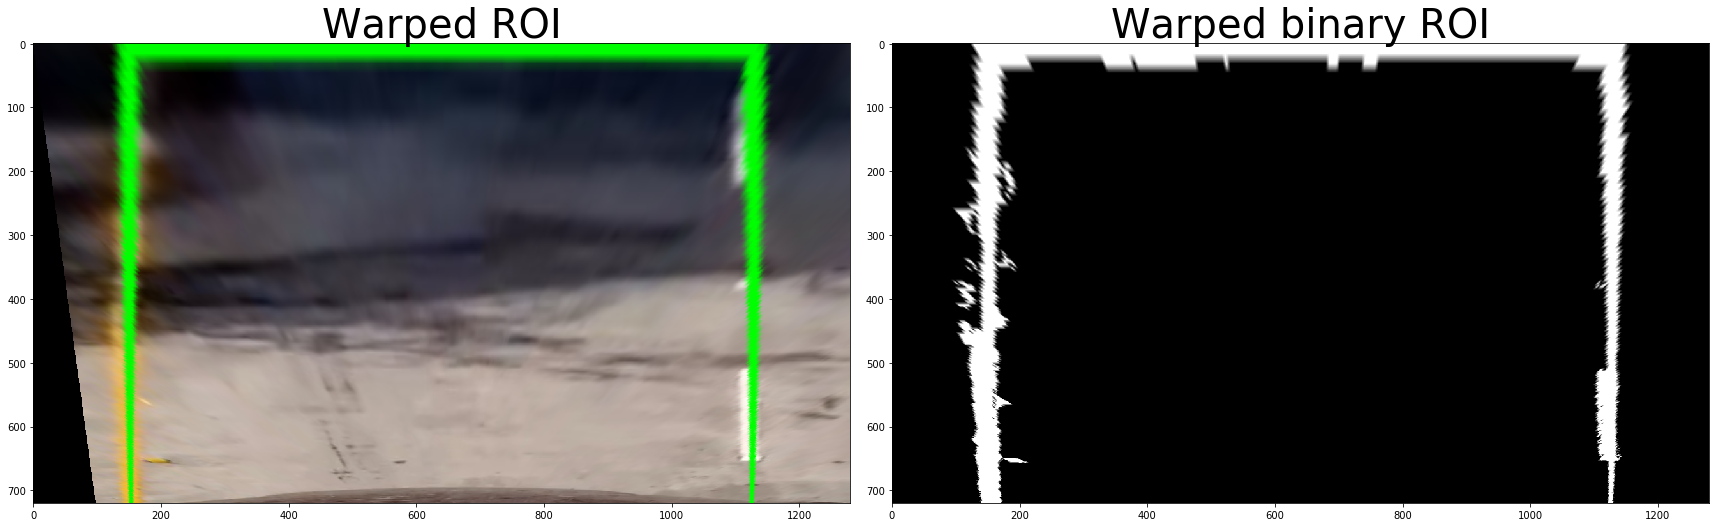

In [12]:
def warp_pipeline(img):
    undist = undistort(img)    
    result = warp(undist)
    result = region_of_interest(result)
    return result
    
def warp_binarize_pipeline(img):
    undist = undistort(img)
    binary,_  = binarize(undist)
    result = warp(binary)
    result = region_of_interest(result)
    return result 

warp_roi = warp_pipeline(img)
warp_binary_roi = warp_binarize_pipeline(img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warp_roi)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warp_binary_roi)
ax2.set_title('Warped binary ROI', fontsize=40)

### 2.6 Inverse perspective transform function
* After process the image , I need to inverse the perspective to origin image, so I define a perspective inverse function 'Minv(img)' here.

In [13]:
def Minv(img):
    corners = np.float32([[570,470],[170,720], [1145,720],[735,470]])
    offset = 150

    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [corners[0],
         corners[1],
         corners[2],
         corners[3]])

    dst = np.float32([
        [offset, 0], 
        [offset, img_size[1]],                         
        [img_size[0] - offset, img_size[1]],            
        [img_size[0] - offset,0]])   

    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv

## 3. The lane-extraction pipline
main process of this pipeline. It gets a image as input , and gives a output of image masked with extract lane. 
1. get binary-pixel image by using the function warped_binarzie_pipeline().
2. use a histogram of pixel to find left line and right line.
3. saperate lines by using the histogram and sliding windows to find left-line and right-line pixels' position indices.
4. use the indices to fit a 2nd order polynominal function(y =ax^2+bx+c). Then the position and curvature of two lines can be calculated. The region between two lines is the lane that is extracted. The distance from vehicle'position to the center of the lane can also be easily calculated from the intersection coordinate of the lines and the bottom side of the image.
5. After getting the formular of the line, the pixel coordinate should be converted to the real-world coordinate by using the formular as follows:ym_per_pix = 3.0/72.0  xm_per_pix = 3.7/660.0
6. use 'cv2.fill poly' to visualize the lane and add curvature and 'position from center position' on the image.

In [14]:
#main process to extract_lane from image
def extract_lane(img):
    #process the image with warp_binarize_pipeline
    warped_binary = warp_binarize_pipeline(img)
    
    #convert 'warped_binary' to gray. This step is in order to reduce the scale of the image.
    binary_warped = cv2.cvtColor(warped_binary,cv2.COLOR_RGB2GRAY)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ##################################################################################
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ##################################################################################
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    #################################################################################
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    #################################################################################
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    midx = 650
    
    #generate the curvature based on real world transfrom with pexel relationship. 
    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    #curvature calculate based on extract left line .
    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    
    #############################################################################################
    #calculate the position from center by using the x position in left line and right line.
    #Using the 2nd order polynomial function to generate x left pixel postion and x right pixel position.
    x_left_pix =left_fit[0]*(y_eval**2) + left_fit[1]*y_eval +left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval +right_fit[2]
    pos_from_center = ((x_left_pix + x_right_pix)/2.0 - midx) * xm_per_pix
    
    ##############################################################################################
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv(img), (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistort(img), 1, newwarp, 0.3, 0)
    
    ###############################################################################################
    #add pos_from_center and curvature string on the image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1=str('position from center is : '+ str(pos_from_center) + 'm')
    cv2.putText(result,str1,(280,50),font,1,(255,255,255),2,cv2.LINE_AA)
    str2 = str('radius of curvature: '+str(curvature*0.001)+'km')
    cv2.putText(result,str2,(280,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    return result


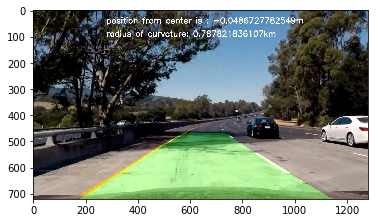

In [15]:
#test the extract_lane fucntion with test image.
plt.imshow(extract_lane(image))

## 4.Vedio processing pipline
* use the upper lane-extraction pipline to process every single frame
* use the 'VideoFileClip' library to extract image in video and process the image one by one. 
* 'VideoFileClip' library read video, and extract image to function main(), then main() process every single image and gives a output to 'VideoFileClip'.
* the every image processed by main function will be regathered with a new video named 'output_video_kr.mp4'

In [16]:
# main process used in VideoFileClip defined.
def main(img):
    result = extract_lane(img)
    return result

In [17]:
import pickle
import glob
import scipy
from scipy import signal
from collections import deque
import imageio

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
output = './output_video_kr.mp4'
clip = VideoFileClip("./project_video.mp4")

In [19]:
out_clip = clip.fl_image(main)
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video_kr.mp4
[MoviePy] Writing video ./output_video_kr.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:05<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video_kr.mp4 

Wall time: 4min 6s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## 5.Discussion
### 5.1 problems/issues faced
* In warp and binarize part, how to generate the useful features from image. 
* The warp vertices and binarize threshold were hard to tune. There are no specific requirement. So I don't know if the result is good enough.
* There are still so many hyperparameter need to be tuned by hand. I don't know if it can still work well in other scenarios.

### 5.2 what could be improved about algorithm/pipeline
* The sliding window algorithm was not used here. If use sliding window algorith, I think the processing will run faster. 
* I think machine learning algorithm can help us find points, edges, rectangle, circle and even the inner relationship of pixels and frames. Maybe the CNN and RNN can be used here to extract information from flowing image stream.
* If the light condition is not good, as in harder_challenge_video.mp4, my pipline can't work well. I would like to get some reference materials that is helpful for challenge_video and harder_challenge_video. 

### 5.3 what hypothetical cases would cause pipeline to fail 
* The lane lines are not clear 
* The scenario is not daytime but at night
* There are cars on the line lanes
* The ground reflects the light(as in harder_challenge_video.mp4)
* Heavy raining days and foggy days